In [1]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,logging,pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
import re
import pandas as pd
from matplotlib import pyplot as plt

# logging.set_verbosity_info()

## Download the dataset

In [2]:
ds = load_dataset("zeroshot/twitter-financial-news-sentiment")
# ds = load_dataset("warwickai/financial_phrasebank_mirror")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
ds.shape

{'train': (9543, 2), 'validation': (2388, 2)}

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

## Preprocess the data

In [7]:
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)   # remove URLs
    text = re.sub(r"\$\w+", "", text)     # remove tickers like $BYND
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)  # remove mentions
    return text.strip()
ds = ds.map(lambda x: {"text": clean_tweet(x["text"])})

In [8]:
def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)


In [9]:
encoded_dataset = ds.map(preprocess, batched=True)

In [10]:
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [11]:
def print_gpu_usage(tag=""):
    if torch.cuda.is_available():
        print(f"[{tag}] GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"[{tag}] GPU memory reserved:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")


## Full Fine-tuning

In [12]:
print_gpu_usage("Initial State")

[Initial State] GPU memory allocated: 0.00 GB
[Initial State] GPU memory reserved:  0.00 GB


In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3,hidden_dropout_prob=0.3,  # add drop out
    attention_probs_dropout_prob=0.3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./results_BERT_full_finetune",
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    load_best_model_at_end=True,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
)


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-449286851.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
trainer.train()


wandb: Currently logged in as: yhchen1766 (yhchen1766-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.730300,0.514310,0.805695,0.749386
2,0.502600,0.403164,0.847571,0.798934
3,0.414000,0.367447,0.862228,0.820952
4,0.356500,0.399690,0.847571,0.816504
5,0.306200,0.404799,0.860134,0.828915
6,0.269500,0.363892,0.875628,0.844302
7,0.241000,0.391690,0.861390,0.828419
8,0.209400,0.400977,0.880653,0.845351
9,0.186100,0.431155,0.881910,0.850931
10,0.158000,0.439585,0.872697,0.843736


TrainOutput(global_step=5980, training_loss=0.2197616918429882, metrics={'train_runtime': 1049.8865, 'train_samples_per_second': 181.791, 'train_steps_per_second': 5.696, 'total_flos': 1.255445672689152e+16, 'train_loss': 0.2197616918429882, 'epoch': 20.0})

In [18]:
print("Full fine-tune GPU usage:")
print_gpu_usage("Full")

Full fine-tune GPU usage:
[Full] GPU memory allocated: 1.38 GB
[Full] GPU memory reserved:  4.32 GB


In [19]:
trainer.evaluate()

{'eval_loss': 0.3638923764228821,
 'eval_accuracy': 0.8756281407035176,
 'eval_f1': 0.8443017950527255,
 'eval_runtime': 3.769,
 'eval_samples_per_second': 633.595,
 'eval_steps_per_second': 10.082,
 'epoch': 20.0}

In [20]:
full_logs = pd.DataFrame(trainer.state.log_history)
full_logs["setup"] = "Full Fine-Tuning"

In [29]:
del model, trainer
torch.cuda.empty_cache()

## LoRA

In [30]:
print_gpu_usage("LoRA Initial")

[LoRA Initial] GPU memory allocated: 0.48 GB
[LoRA Initial] GPU memory reserved:  0.50 GB


In [31]:
from peft import LoraConfig, get_peft_model

# 1. Load base model
model_lora = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 2. Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # apply LoRA on attention layers
    lora_dropout=0.3,
    bias="none",
    task_type="SEQ_CLS",
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# 3. Wrap model with LoRA
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [33]:
# 4. Training
training_args = TrainingArguments(
    output_dir="./results_lora",
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,   # higher LR for LoRA
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs_lora",
    logging_strategy="epoch",
)

trainer_lora = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1173109926.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


In [34]:
trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.710800,0.581931,0.767169,0.627743
2,0.509600,0.414728,0.843384,0.776461
3,0.418700,0.382442,0.853853,0.801677
4,0.371400,0.387903,0.853434,0.813938
5,0.330000,0.386438,0.864740,0.821526
6,0.298700,0.363332,0.871859,0.826748
7,0.271000,0.369878,0.875628,0.832872
8,0.252400,0.387935,0.865159,0.824138
9,0.230000,0.378032,0.874791,0.835223
10,0.208900,0.398435,0.876047,0.835774


TrainOutput(global_step=5980, training_loss=0.2549442769691697, metrics={'train_runtime': 782.4231, 'train_samples_per_second': 243.935, 'train_steps_per_second': 7.643, 'total_flos': 1.259802323057664e+16, 'train_loss': 0.2549442769691697, 'epoch': 20.0})

In [35]:
print("LoRA fine-tune GPU usage:")
print_gpu_usage("LoRA")

LoRA fine-tune GPU usage:
[LoRA] GPU memory allocated: 0.46 GB
[LoRA] GPU memory reserved:  2.87 GB


In [36]:
trainer_lora.evaluate()

{'eval_loss': 0.4872523546218872,
 'eval_accuracy': 0.8777219430485762,
 'eval_f1': 0.8393547680208909,
 'eval_runtime': 3.9624,
 'eval_samples_per_second': 602.665,
 'eval_steps_per_second': 9.59,
 'epoch': 20.0}

In [37]:
lora_logs = pd.DataFrame(trainer_lora.state.log_history)
lora_logs["setup"] = "LoRA Fine-Tuning"

## Evaluation and Comparison

In [56]:

# Combine logs
logs = pd.concat([full_logs, lora_logs])

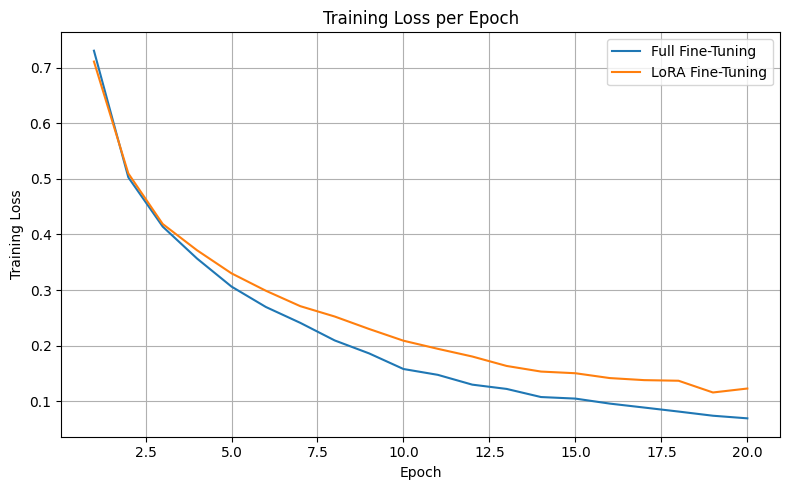

In [57]:
# Filter only training logs (where eval_loss is NaN)
train_logs = logs[~logs["loss"].isna()]

plt.figure(figsize=(8, 5))
for setup, df in train_logs.groupby("setup"):
    plt.plot(df["epoch"], df["loss"], label=setup)

plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


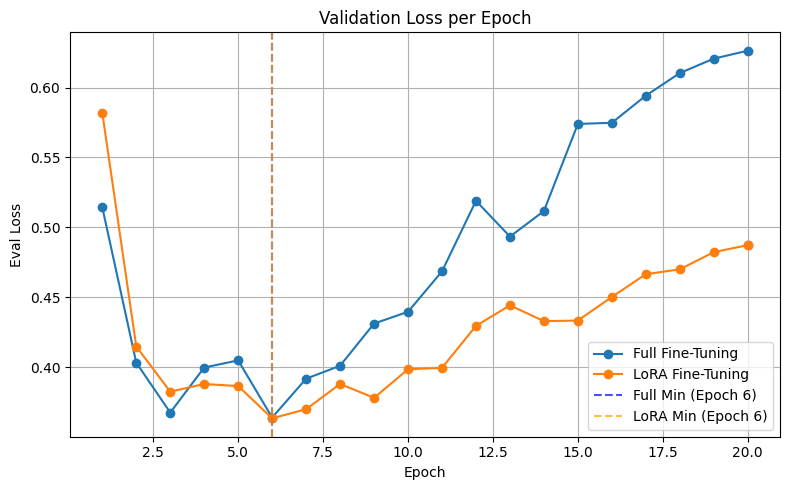

In [58]:
eval_full = full_logs[full_logs["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]
eval_lora = lora_logs[lora_logs["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]
plt.figure(figsize=(8,5))
plt.plot(eval_full["epoch"][0:20], eval_full["eval_loss"][0:20], label="Full Fine-Tuning", marker="o")
plt.plot(eval_lora["epoch"], eval_lora["eval_loss"], label="LoRA Fine-Tuning", marker="o")

# Find the minimum loss for best performance epoch
min_idx_full = eval_full["eval_loss"][0:20].idxmin()
min_epoch_full = eval_full.loc[min_idx_full, "epoch"]
plt.axvline(x=min_epoch_full, color='blue', linestyle='--', alpha=0.7, label=f'Full Min (Epoch {min_epoch_full:.0f})')

min_idx_lora = eval_lora["eval_loss"].idxmin()
min_epoch_lora = eval_lora.loc[min_idx_lora, "epoch"]
plt.axvline(x=min_epoch_lora, color='orange', linestyle='--', alpha=0.7, label=f'LoRA Min (Epoch {min_epoch_lora:.0f})')

plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Eval Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For both full fine-tuning and LoRA fine-tuning method, the minimum evalution loss happens when epoch=6. After epoch > 6, the loss keep increasing, which represents that the model is overfitting

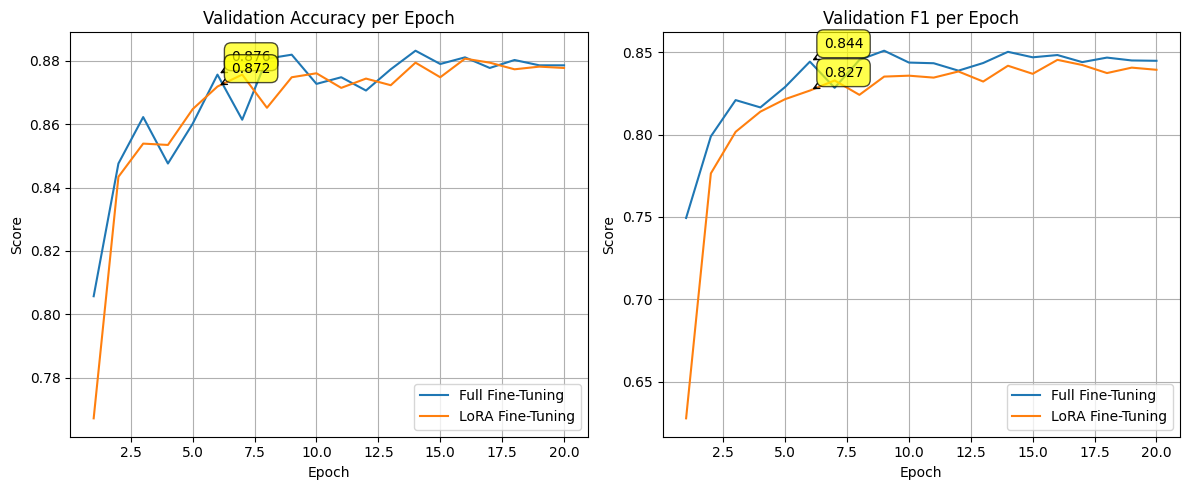

In [59]:
# Keep only eval metrics
eval_logs = logs[logs["loss"].isna()]  # only evaluation steps

# Plot Accuracy & F1
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for setup, df in eval_logs.groupby("setup"):
    ax[0].plot(df["epoch"], df["eval_accuracy"], label=setup)
    ax[1].plot(df["epoch"], df["eval_f1"], label=setup)

    epoch_6_data = df[df["epoch"] == 6]

    acc_val = epoch_6_data["eval_accuracy"].values[0]
    f1_val = epoch_6_data["eval_f1"].values[0]

    ax[0].annotate(f'{acc_val:.3f}',
                  xy=(6, acc_val),
                  xytext=(10, 10),
                  textcoords='offset points',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    ax[1].annotate(f'{f1_val:.3f}',
                  xy=(6, f1_val),
                  xytext=(10, 10),
                  textcoords='offset points',
                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))


ax[0].set_title("Validation Accuracy per Epoch")
ax[1].set_title("Validation F1 per Epoch")
for a in ax:
    a.set_xlabel("Epoch")
    a.set_ylabel("Score")
    a.legend()
    a.grid(True)
plt.tight_layout()
plt.show()


### Evaluation with FinBERT

In [62]:

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [64]:
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

Device set to use cuda:0


In [65]:
# Load dataset
ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [66]:
# Label mapping
# Dataset: 0=Bearish, 1=Bullish, 2=Neutral
# FinBERT: LABEL_0=Neutral, LABEL_1=Positive, LABEL_2=Negative
# We need to map: Bearish->Negative(2), Bullish->Positive(1), Neutral->Neutral(0)
dataset_to_finbert = {
    0: 2,  # Bearish -> Negative
    1: 1,  # Bullish -> Positive
    2: 0   # Neutral -> Neutral
}

finbert_to_dataset = {
    0: 2,  # Neutral -> Neutral
    1: 1,  # Positive -> Bullish
    2: 0   # Negative -> Bearish
}

In [68]:
def evaluate_finbert(dataset_split, model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    texts = dataset_split['text']
    true_labels = dataset_split['label']

    predictions = []
    all_losses = []
    loss_fct = CrossEntropyLoss()

    with torch.no_grad():
        for i, text in enumerate(texts):
            # Tokenize
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get model output
            outputs = model(**inputs)
            logits = outputs.logits

            # Get prediction (FinBERT label)
            pred_finbert = torch.argmax(logits, dim=1).item()

            # Convert to dataset label
            pred_dataset = finbert_to_dataset[pred_finbert]
            predictions.append(pred_dataset)

            # Calculate loss using mapped labels
            true_label_finbert = dataset_to_finbert[true_labels[i]]
            labels = torch.tensor([true_label_finbert]).to(device)
            loss = loss_fct(logits, labels)
            all_losses.append(loss.item())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    avg_loss = np.mean(all_losses)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': predictions
    }


In [70]:
# Evaluate on train set
print("Evaluating on training set...")
train_results = evaluate_finbert(ds['train'], finbert, tokenizer)
print(f"Train Loss: {train_results['loss']:.4f}")
print(f"Train Accuracy: {train_results['accuracy']:.4f}")
print(f"Train F1: {train_results['f1']:.4f}")

Evaluating on training set...
Train Loss: 2.0223
Train Accuracy: 0.7362
Train F1: 0.7290


In [69]:
print("\nEvaluating on validation set...")
val_results = evaluate_finbert(ds['validation'], finbert, tokenizer)
print(f"Validation Loss: {val_results['loss']:.4f}")
print(f"Validation Accuracy: {val_results['accuracy']:.4f}")
print(f"Validation F1: {val_results['f1']:.4f}")


Evaluating on validation set...
Validation Loss: 1.8951
Validation Accuracy: 0.7483
Validation F1: 0.7424


#### After cleaning

In [71]:
ds_clean = ds.map(lambda x: {"text": clean_tweet(x["text"])})

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [72]:
train_cl_results = evaluate_finbert(ds_clean['train'], finbert, tokenizer)
print(f"Train Loss: {train_results['loss']:.4f}")

Train Loss: 2.0223


In [73]:
print("\nEvaluating on validation set...")
val_cl_results = evaluate_finbert(ds_clean['validation'], finbert, tokenizer)
print(f"Validation Loss: {val_results['loss']:.4f}")
print(f"Validation Accuracy: {val_results['accuracy']:.4f}")
print(f"Validation F1: {val_results['f1']:.4f}")


Evaluating on validation set...
Validation Loss: 1.8951
Validation Accuracy: 0.7483
Validation F1: 0.7424
